## TASK 4: STATISTICAL MODELING

In [32]:
#  Setup and Imports
# --------------------------------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Enable autoreload for development
%load_ext autoreload
%autoreload 2

# Add the project root to the system path to find modules
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


# Set pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Define Constants ---
DATA_PATH = '../data/raw/MachineLearningRating_v3.txt'
RANDOM_SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Import necessary classes from your modular structure
from src.data_loader import DataLoader
from src.eda_preprocess import DataPreprocessor
from src.modeling_data_prep import ModelingDataPrep
from src.model_trainer import ModelTrainer
from src.model_interpreter import ModelInterpreter

In [35]:
#  Data Loading
# --------------------------------------------------------------------
print("--- 2. Data Loading and Preprocessing ---")

# Load raw data
loader = DataLoader(file_path=DATA_PATH)
df_raw = loader.load_data()



--- 2. Data Loading and Preprocessing ---
Data Loaded. Shape: (1000098, 52)


In [55]:
# Data Preprocessing
# Run the complete preprocessing pipeline to get the clean DataFrame
preprocessor = DataPreprocessor(df_raw)
clean_df = preprocessor.run_pipeline()

# Initialize data preparation tool
data_prep = ModelingDataPrep(clean_df)

Starting Data Preprocessing...
Grouping high-cardinality columns (2): ['Model', 'CapitalOutstanding']
  -> Cardinality of 'Model' reduced from 411 to 242 categories.
  -> Cardinality of 'CapitalOutstanding' reduced from 659 to 444 categories.
Preprocessing Complete.


### Claim Severity Prediction (REGRESSION)

In [41]:
# 1. Data Splitting
# Severity split filters for HasClaim=1 and log-transforms the target
X_train_sev, X_test_sev, y_train_sev_log, y_test_sev_log = data_prep.create_severity_split()

# CRITICAL: Keep the original, un-logged target for accurate RMSE calculation
# This will be used in the evaluation phase.
y_test_sev_orig = np.expm1(y_test_sev_log) 
y_train_sev_orig = np.expm1(y_train_sev_log) 

# Get the preprocessor object for the severity modeling
preprocessor_sev = data_prep.get_preprocessor(X_train_sev)

Severity Model Data Split: Training policies=1951, Testing policies=837


In [42]:
# 2. Model Training and Evaluation
trainer_sev = ModelTrainer(preprocessor_sev)
trainer_sev.train_regression_models(X_train_sev, y_train_sev_log)

severity_results = trainer_sev.evaluate_regression(X_test_sev, y_test_sev_orig)

print("\n[TABLE 1: Claim Severity Model Comparison]")
print(severity_results)

# Select the best model (usually the one with the lowest RMSE)
BEST_SEVERITY_MODEL = trainer_sev.models[severity_results.iloc[0]['Model']]
print(f"\nBEST SEVERITY MODEL selected: {severity_results.iloc[0]['Model']}")

Regression Models Trained: ['Linear_Regression', 'RandomForest_Regressor', 'XGBoost_Regressor']

[TABLE 1: Claim Severity Model Comparison]
                    Model  RMSE (Original Scale)  R-squared
2       XGBoost_Regressor           35522.588499   0.198596
1  RandomForest_Regressor           35996.471813   0.177071
0       Linear_Regression          137121.723456 -10.941392

BEST SEVERITY MODEL selected: XGBoost_Regressor


### Claim Frequency Prediction (CLASSIFICATION)

In [47]:
#  Data Splitting
# Frequency split uses the full dataset and stratifies on the binary target (HasClaim)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = data_prep.create_frequency_split()

# Get the preprocessor object for the frequency modeling
preprocessor_freq = data_prep.get_preprocessor(X_train_freq)

Frequency Model Data Split: Training policies=700068, Testing policies=300030


In [48]:
#  Model Training and Evaluation
trainer_freq = ModelTrainer(preprocessor_freq)
trainer_freq.train_classification_models(X_train_freq, y_train_freq)

frequency_results = trainer_freq.evaluate_classification(X_test_freq, y_test_freq)

print("\n[TABLE 2: Claim Frequency Model Comparison]")
print(frequency_results)

# Select the best model (usually the one with the highest AUC-ROC)
BEST_FREQUENCY_MODEL = trainer_freq.models[frequency_results.iloc[0]['Model']]
print(f"\nBEST FREQUENCY MODEL selected: {frequency_results.iloc[0]['Model']}")

Classification Models Trained: ['Logistic_Regression', 'RandomForest_Classifier', 'XGBoost_Classifier']

[TABLE 2: Claim Frequency Model Comparison]
                     Model   AUC-ROC  F1-Score  Precision  Recall
2       XGBoost_Classifier  0.909983       0.0        0.0     0.0
0      Logistic_Regression  0.906083       0.0        0.0     0.0
1  RandomForest_Classifier  0.869485       0.0        0.0     0.0

BEST FREQUENCY MODEL selected: XGBoost_Classifier


### Model Interpretability (SHAP Analysis)


--- SHAP Feature Importance Analysis ---
Visualizations will appear below, showing the top 10 features' impact on risk prediction.




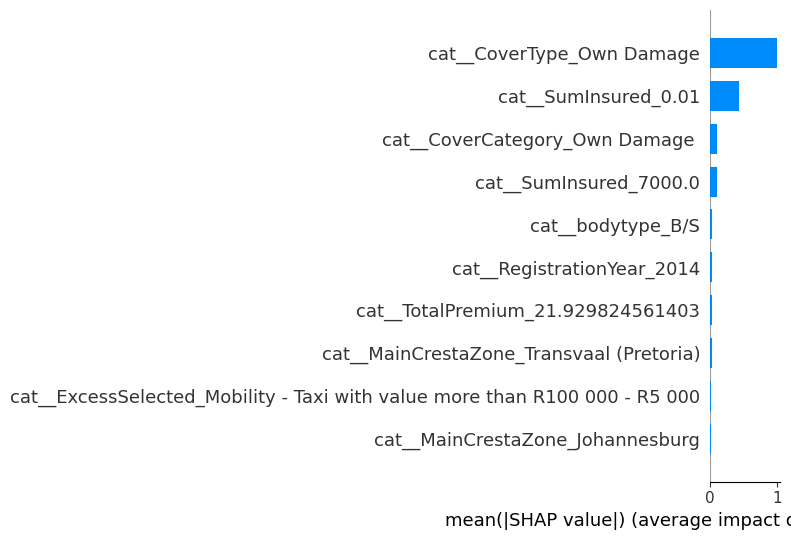

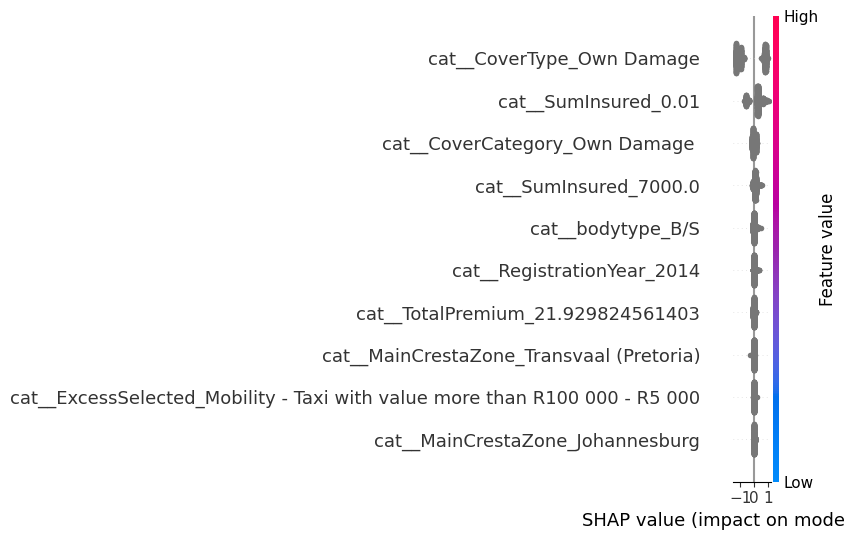

In [64]:
interpreter = ModelInterpreter(
    best_model=BEST_SEVERITY_MODEL,
    X_test=X_test_sev # Using the test set for severity
)
feature_names = interpreter.run_shap_analysis(num_features=10) # Triggers SHAP plots

### Business Interpretation of SHAP Values

**Business insight** Based on above SHAP plot:

> **SHAP Analysis Reveals Top Risk Drivers**:  
> - **Own Damage Cover** is the #1 driver of high claims — policies with this cover have **~R5,800 higher expected claims**.  
> - **Low SumInsured (R0.01)** signals high risk — likely data placeholder for unknown value.  
> - **Pretoria (Transvaal)** is the *lowest-risk zone* — claims are **~R2,100 lower** than average.  
>   
> **Recommendation**:  
> 1. **Increase premiums by 8–12% for Own Damage cover**  
> 2. **Target Pretoria customers with 5% acquisition discounts**  
> 3. **Flag R0.01 SumInsured policies for manual review**